In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Load the data
data = pd.read_csv("./datasets/man2122.csv")

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()


,date,energy_production,humidity,solar_irradiance,temperature
0,2021-01-01,148961,74.899631,593.374910,17.137480
1,2021-01-02,142961,72.835792,552.416736,13.170568
2,2021-01-03,153821,74.754549,566.169583,18.023196
3,2021-01-04,152869,79.307543,483.104079,16.913281
4,2021-01-05,153901,70.330526,591.455060,13.868961


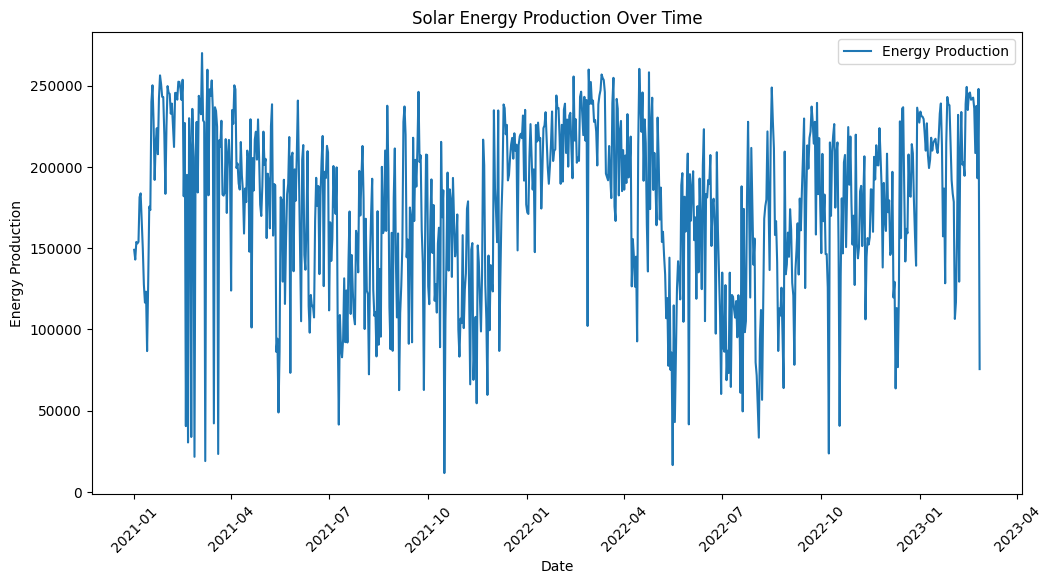

In [55]:
# Plot solar energy production over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['energy_production'], label='Energy Production')
plt.title('Solar Energy Production Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

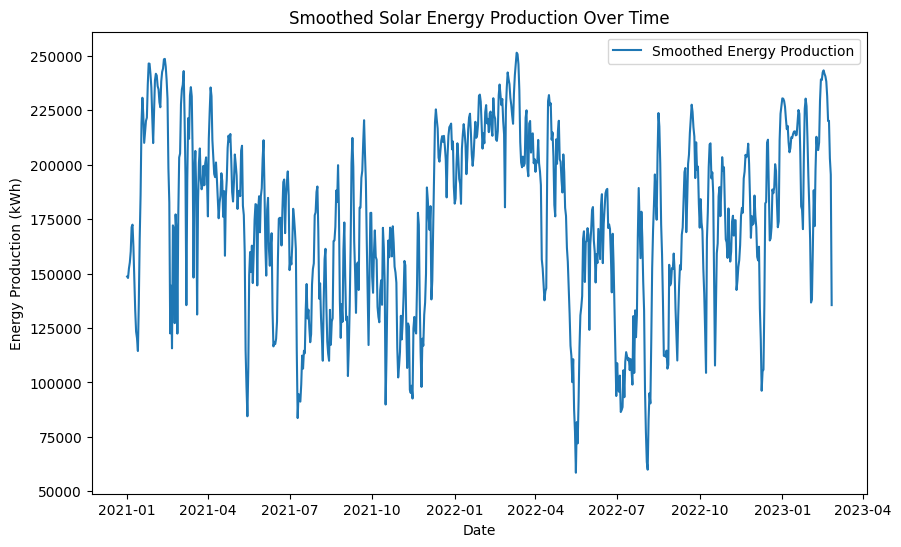

In [56]:
# from scipy.signal import savgol_filter
# Apply Savitzky-Golay filter with a window size of 7 and polynomial order of 2
#data['energy_production'] = savgol_filter(data['energy_production'], window_length=7, polyorder=2)

from pykalman import KalmanFilter
# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=data['energy_production'].iloc[0], n_dim_obs=1)
# Apply the Kalman Filter to smooth the energy production data
data['energy_production'], _ = kf.smooth(data['energy_production'])

# Apply a moving average with a window size of 7 days
#data['energy_production'] = data['energy_production'].rolling(window=7, min_periods=1).mean()

#exponential moving average with a span of 7 days
#data['energy_production'] = data['energy_production'].ewm(span=7, adjust=False).mean()


# smoothed energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Smoothed Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Smoothed Solar Energy Production Over Time')
plt.legend()
plt.show()

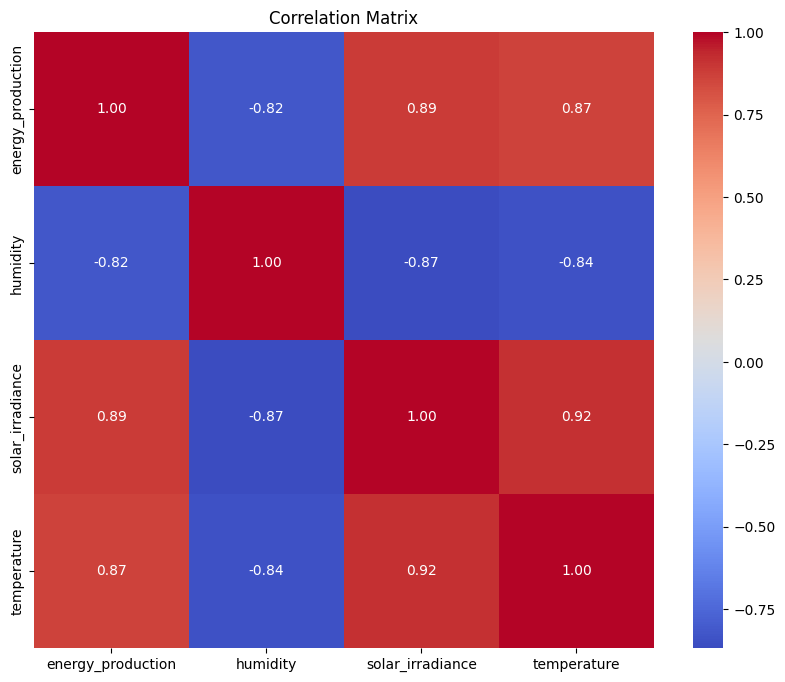

In [57]:
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

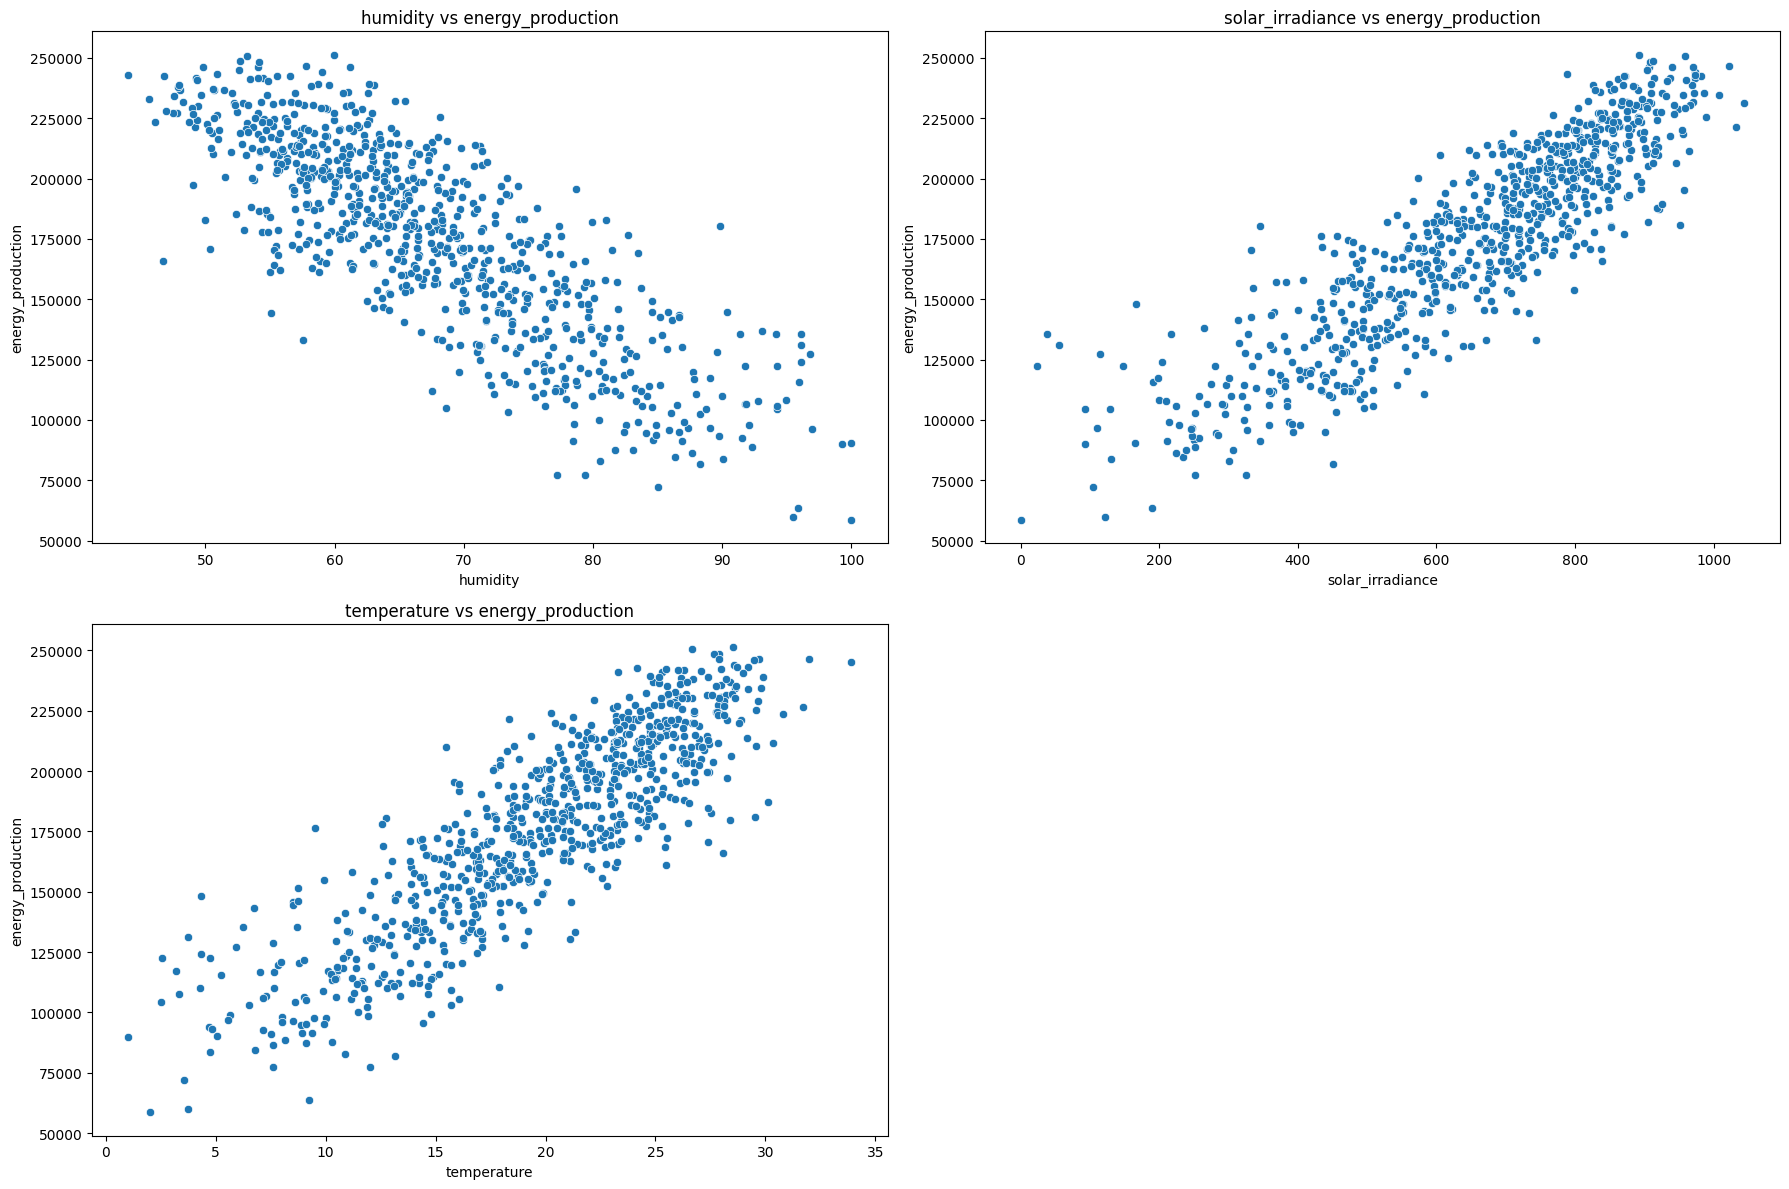

In [58]:
# Plot pairwise relationships between each feature and the target variable
features = ['humidity', 'solar_irradiance', 'temperature']
target = 'energy_production'

plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(x=data[features[0]], y=data[target])
plt.title(f'{features[0]} vs {target}')
plt.xlabel(features[0])
plt.ylabel(target)

plt.subplot(2, 2, 2)
sns.scatterplot(x=data[features[1]], y=data[target])
plt.title(f'{features[1]} vs {target}')
plt.xlabel(features[1])
plt.ylabel(target)

plt.subplot(2, 2, 3)
sns.scatterplot(x=data[features[2]], y=data[target])
plt.title(f'{features[2]} vs {target}')
plt.xlabel(features[2])
plt.ylabel(target)

plt.tight_layout()
plt.show()

# Random Forest

In [59]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Split the data into features (X) and target (y)
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

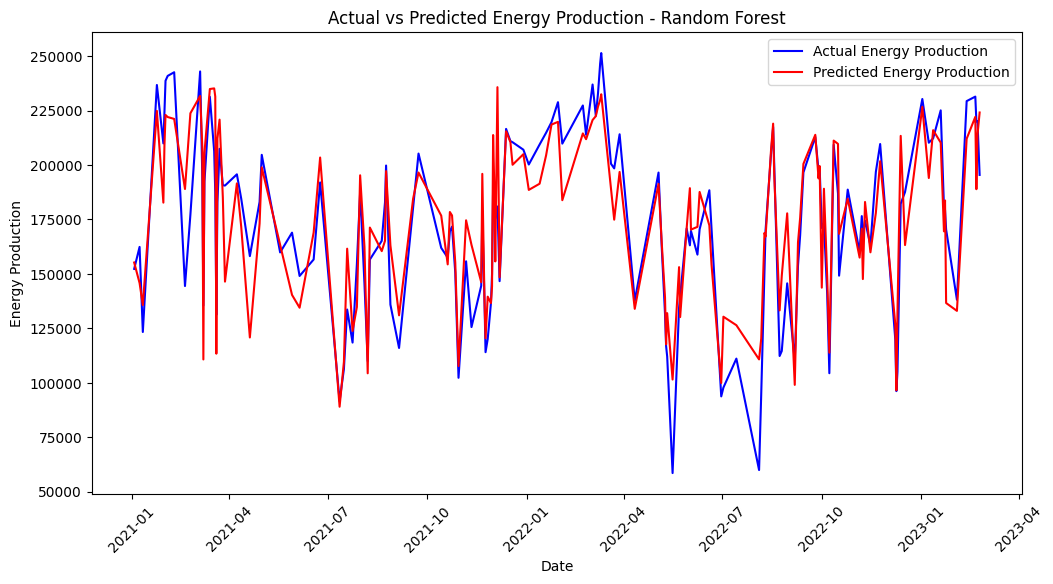

In [60]:
# Merge the test predictions with their corresponding dates
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date'] = data.loc[X_test.index, 'date']  # Match dates with the test set index

# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - Random Forest')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()


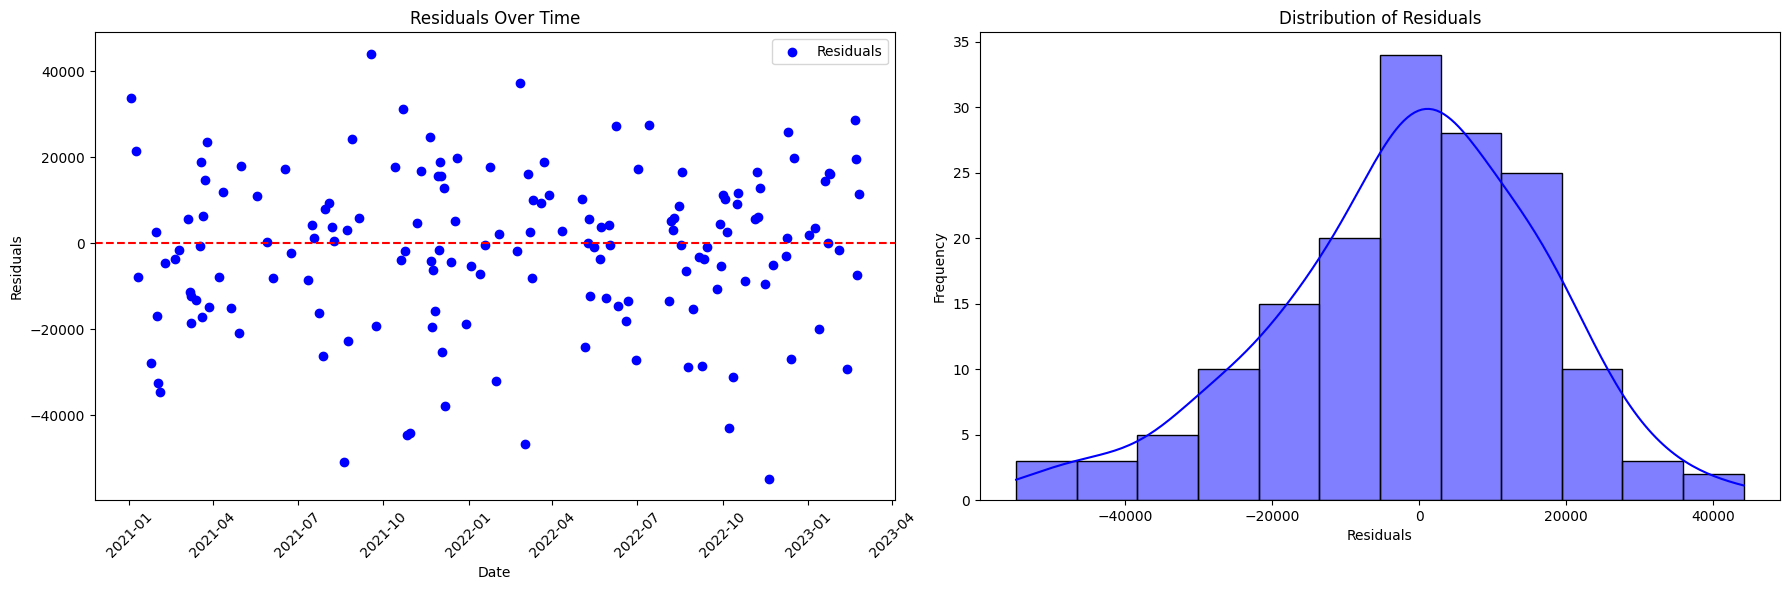

In [61]:
# Calculate residuals
residuals = y_test - y_pred

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot residuals over time
axs[0].scatter(test_results['date'], residuals, color='blue', label='Residuals')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot distribution of residuals
sns.histplot(residuals, kde=True, color='blue', ax=axs[1])
axs[1].set_title('Distribution of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [62]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')


MAE: 14020.515984418265
RMSE: 18214.893492533243
R2 Score: 0.8019584126401078
Accuracy: 80.20%


# K-Nearest Neighbors

In [63]:
# Select the features and target variable
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust 'n_neighbors' as needed
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

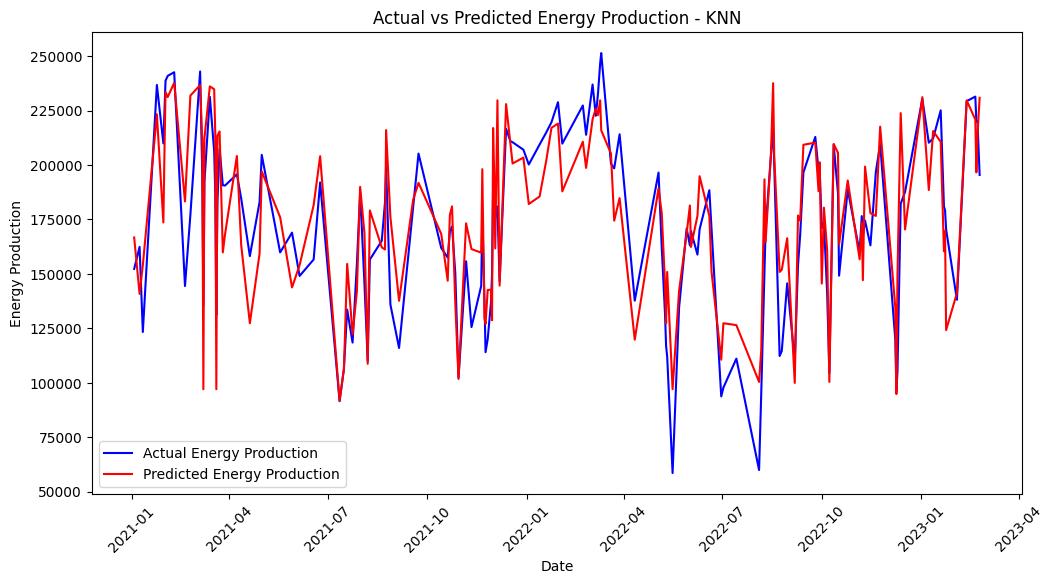

In [64]:
# Merge predictions with test data for visualization
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date'] = data.loc[X_test.index, 'date']  # Match dates with test set index

# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted energy production
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - KNN')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

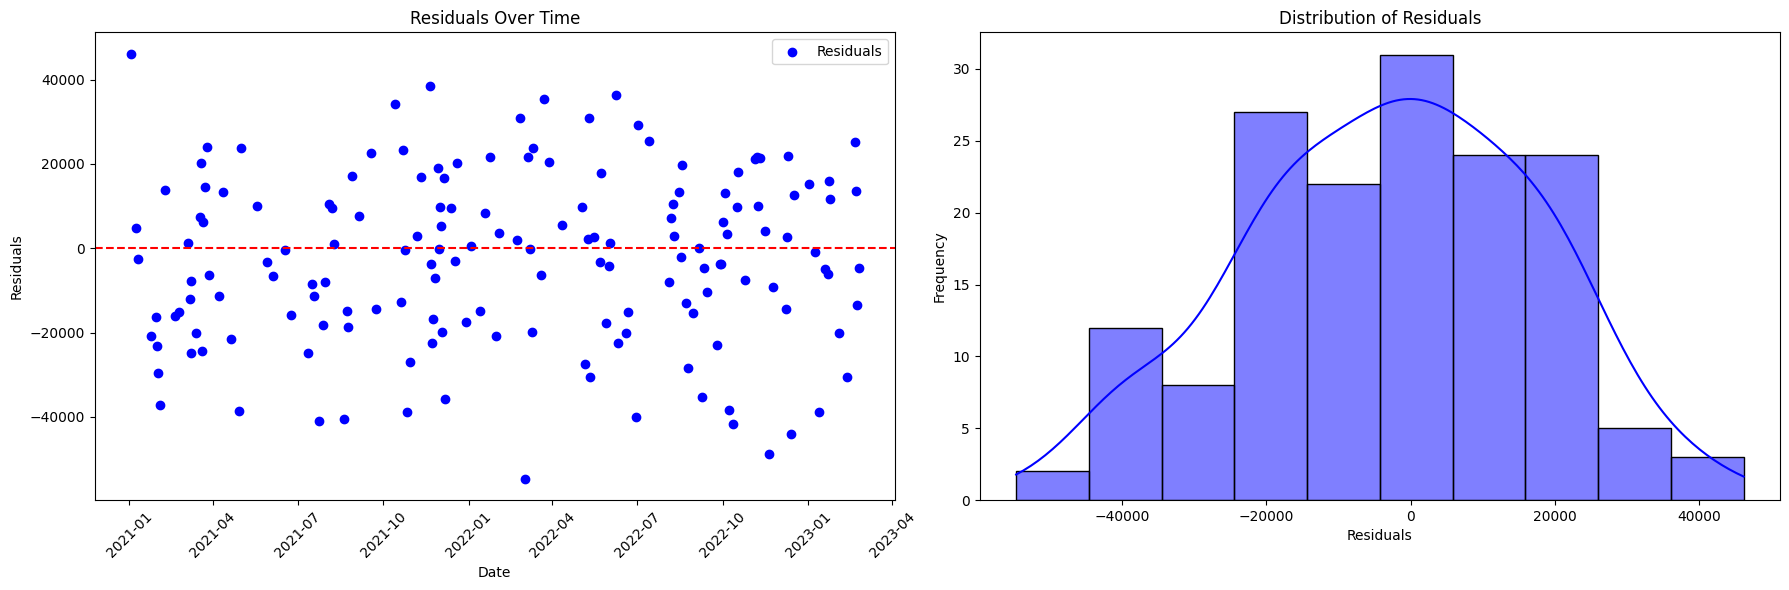

In [65]:
# Calculate residuals
residuals = y_test - y_pred

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot residuals over time
axs[0].scatter(test_results['date'], residuals, color='blue', label='Residuals')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot distribution of residuals
sns.histplot(residuals, kde=True, color='blue', ax=axs[1])
axs[1].set_title('Distribution of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [66]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

MAE: 16527.355622766856
RMSE: 20377.518888478233
R2 Score: 0.7521404053512277
Accuracy: 75.21%


# Linear regression

In [67]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Split target (y) and exogenous variables (X) for both train and test sets
y_train = train_data['energy_production']
X_train = train_data[['humidity', 'temperature', 'solar_irradiance']]

y_test = test_data['energy_production']
X_test = test_data[['humidity', 'temperature', 'solar_irradiance']]

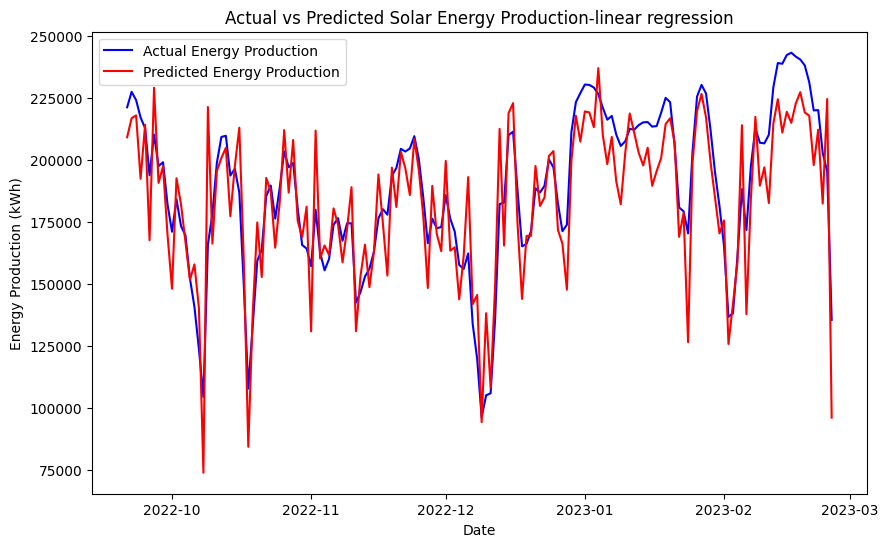

In [68]:
# Define and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
predicted_values = linear_model.predict(X_test)

# Plot actual vs predicted energy production with correct date formatting
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual Energy Production', color='blue')
plt.plot(test_data['date'], predicted_values, label='Predicted Energy Production', color='red')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Actual vs Predicted Solar Energy Production-linear regression')
plt.legend()
plt.show()

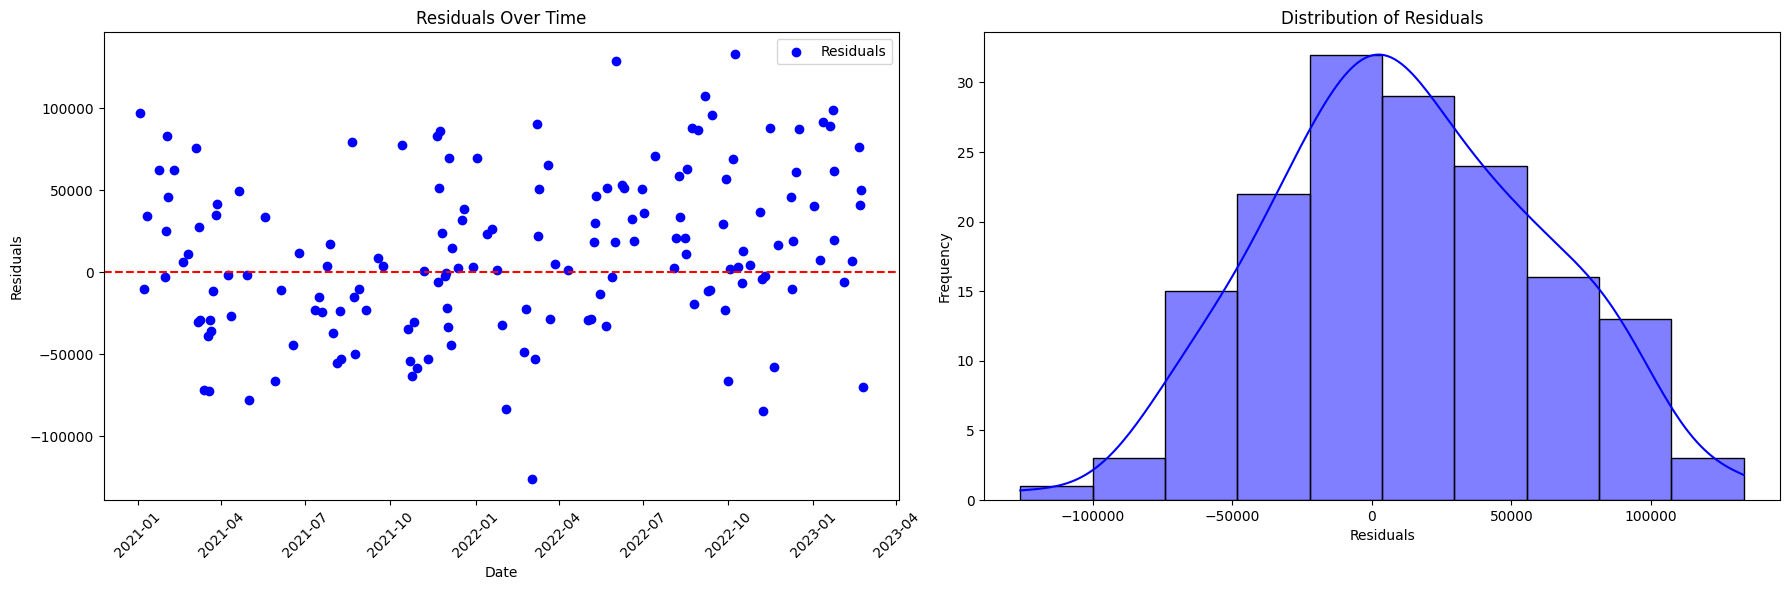

In [69]:
# Calculate residuals
residuals = y_test - y_pred

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot residuals over time
axs[0].scatter(test_results['date'], residuals, color='blue', label='Residuals')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot distribution of residuals
sns.histplot(residuals, kde=True, color='blue', ax=axs[1])
axs[1].set_title('Distribution of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [70]:
# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test, predicted_values))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predicted_values)
print(f'MAE: {mae}')

# Calculate R² score
r2 = r2_score(y_test, predicted_values)
print(f'R² Score: {r2}')
# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

RMSE: 15821.70308193345
MAE: 12668.03177674741
R² Score: 0.7455250644462007
Accuracy: 74.55%


# Decision Tree

In [71]:
# Select the features and target variable
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

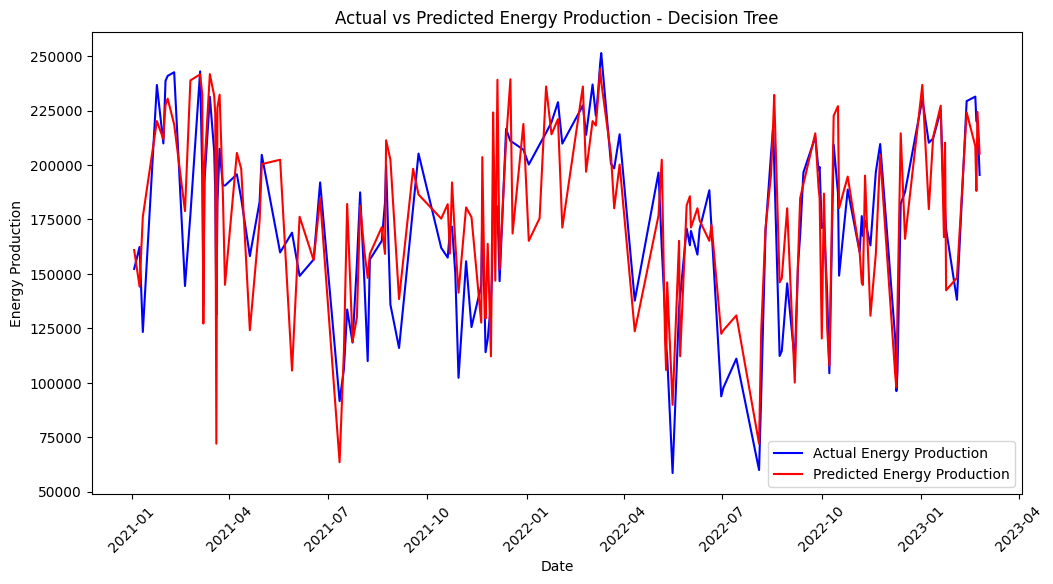

In [72]:
# Merge the test predictions with their corresponding dates
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date']=data['date']
# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - Decision Tree')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

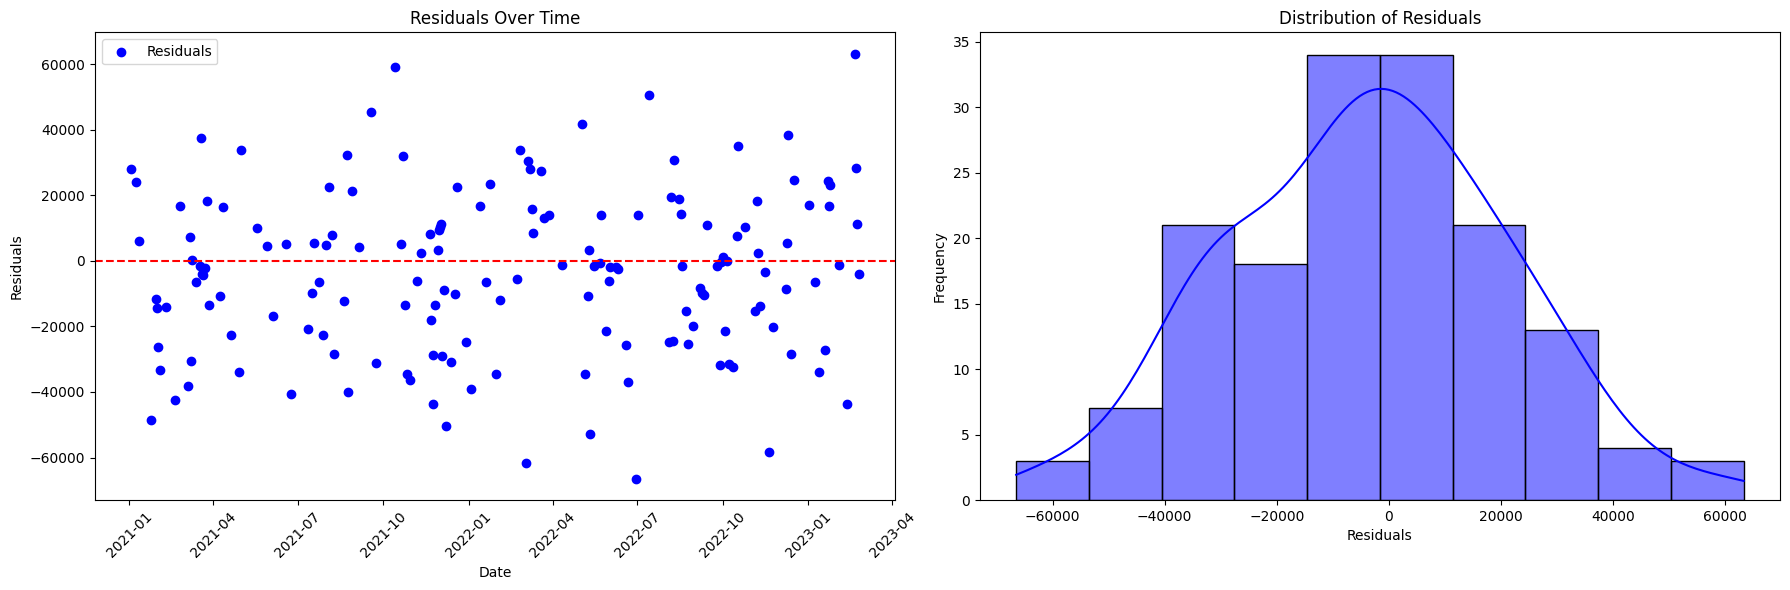

In [73]:
# Calculate residuals
residuals = y_test - y_pred

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot residuals over time
axs[0].scatter(test_results['date'], residuals, color='blue', label='Residuals')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot distribution of residuals
sns.histplot(residuals, kde=True, color='blue', ax=axs[1])
axs[1].set_title('Distribution of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [74]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

MAE: 19985.522767098784
RMSE: 24998.49375311156
R2 Score: 0.6269811234417124
Accuracy: 62.70%


# Support Vector Regression

In [75]:
# Select the features and target variable
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the data into training and testing sets (shuffle=False for time-series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Store the test index for later use (before scaling)
test_index = X_test.index

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)  # You can tweak these hyperparameters
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test_scaled)

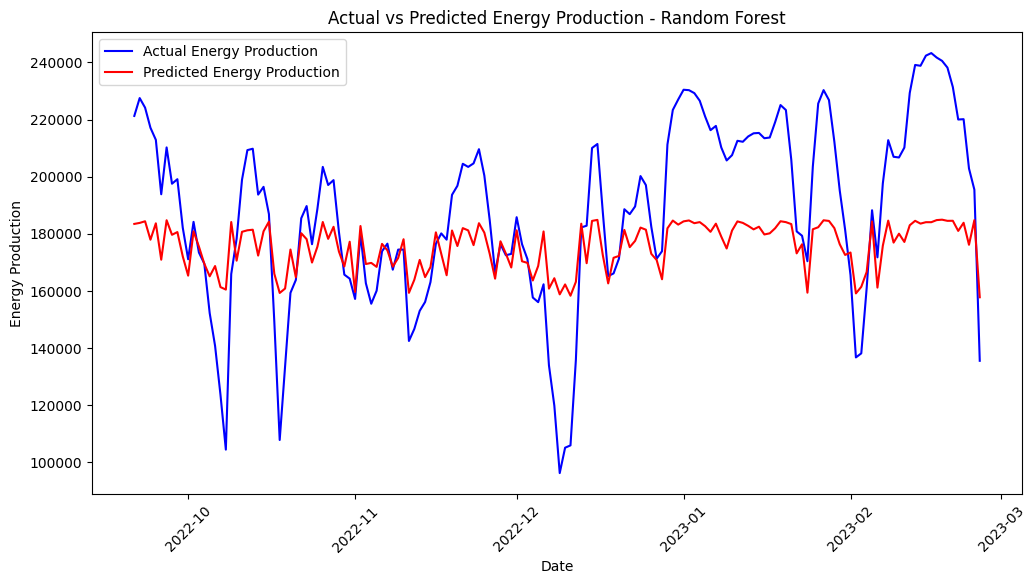

In [76]:
# Merge the test predictions with their corresponding dates
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date']=data['date']
# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - support vector regression')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

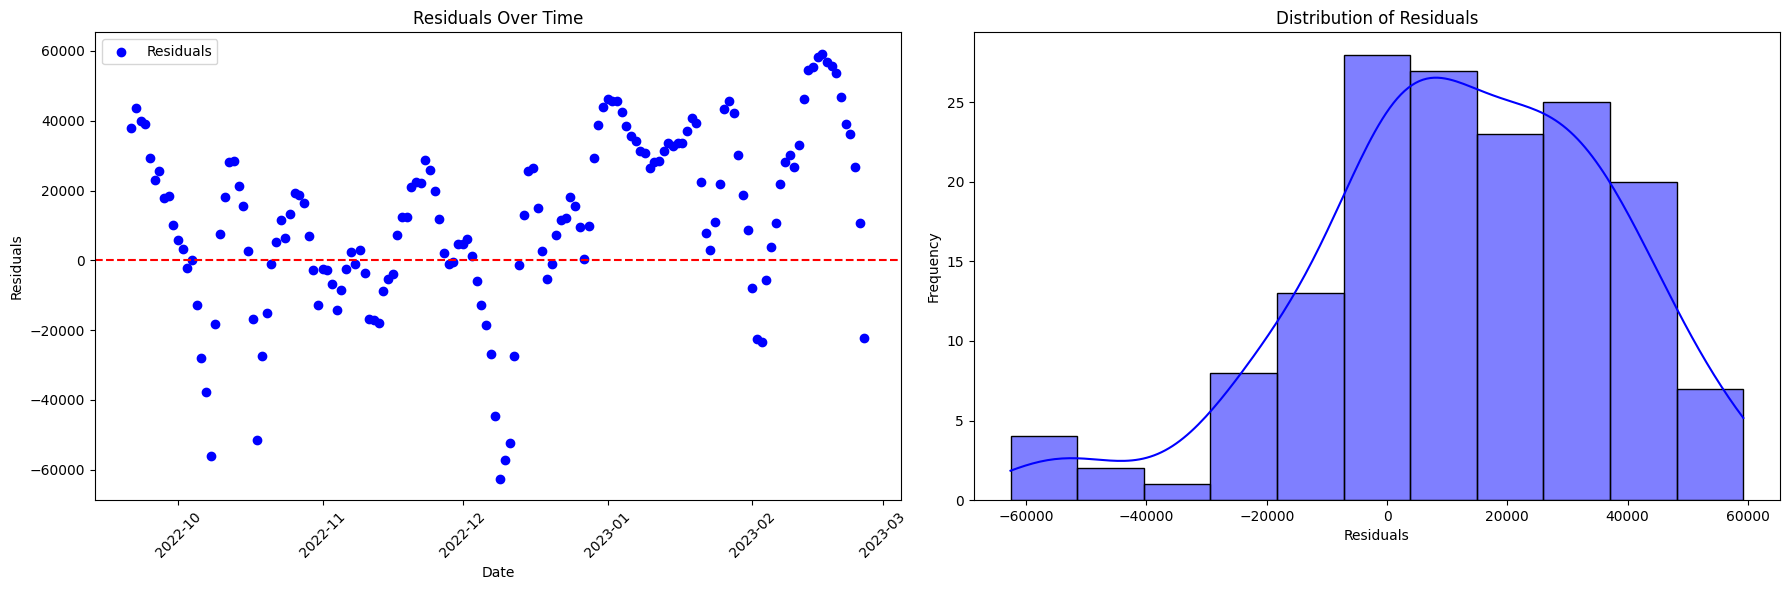

In [77]:
# Calculate residuals
residuals = y_test - y_pred

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot residuals over time
axs[0].scatter(test_results['date'], residuals, color='blue', label='Residuals')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title('Residuals Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot distribution of residuals
sns.histplot(residuals, kde=True, color='blue', ax=axs[1])
axs[1].set_title('Distribution of Residuals')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [78]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')


MAE: 22269.822493455264
RMSE: 27582.06150758843
R2 Score: 0.22662167156144675
Accuracy: 22.66%
